# Libraries

In [123]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
import tensorflow as tf
from darts import TimeSeries
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Load Data

In [124]:
# Since the data is over 100MB, download the csv files from Kaggle and put them in a subfolder called 'Data' in the same directory as this notebook.
# The Data folder is listed in the .gitignore file so only files outside of the Data folder will be pushed to GitHub.
holidays_events = pd.read_csv('Data/holidays_events.csv')
oil = pd.read_csv('Data/oil.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv')
stores = pd.read_csv('Data/stores.csv')
test = pd.read_csv('Data/test.csv')
train = pd.read_csv('Data/train.csv')
transactions = pd.read_csv('Data/transactions.csv')

# fill in missing values for oil with the last valid value
oil = oil.ffill()

In [125]:
familyCodes = None
cityCodes = None
stateCodes = None
typeCodes = None
def add_features(df): # Add date features
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
def add_lags(df):
    # Define a function to add lags within each group
    def add_lags_group(group):
        group['lag_1'] = group['sales'].shift(1)
        group['lag_2'] = group['sales'].shift(2)
        group['lag_3'] = group['sales'].shift(3)
        group['lag_4'] = group['sales'].shift(4)
        group['lag_5'] = group['sales'].shift(5)
        group['lag_6'] = group['sales'].shift(6)
        group['lag_7'] = group['sales'].shift(7)
        return group
    
    # Apply the function within each group of 'store_nbr' and 'family'
    df = df.groupby(['store_nbr', 'family']).apply(add_lags_group)
    
    return df.droplevel([0,1]).sort_index()
def encode_data(train, stores): # Join store information and add date features
    global familyCodes, cityCodes, stateCodes, typeCodes
    df = train.copy()

    # Join Store Information
    df = df.join(stores.set_index('store_nbr'), on='store_nbr')

    # Join Oil Data
    df = df.join(oil.set_index('date'), on='date')

    # Create Date Features
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    df = add_features(df)

    # Encode Categorical Data
    familyCodes = {family: code for code, family in enumerate(df['family'].unique())}
    cityCodes = {city: code for code, city in enumerate(df['city'].unique())}
    stateCodes = {state: code for code, state in enumerate(df['state'].unique())}
    typeCodes = {type: code for code, type in enumerate(df['type'].unique())}
    df['family'] = df['family'].map(familyCodes)
    df['city'] = df['city'].map(cityCodes)
    df['state'] = df['state'].map(stateCodes)
    df['type'] = df['type'].map(typeCodes)

    # Temporary Columns to be dropped for now
    df = df.drop(['id'], axis=1)
    return df
def train_test_split(data, test_size=0.15, verbose=True): # Split the data into training and test set
    df = data.copy()
    dataLength = len(df)
    trainLength = int(dataLength * (1 - test_size))
    df['set'] = 'train'
    df.loc[df.index[trainLength]:, 'set'] = 'test'
    if verbose:
        print('DATES')
        print('Train data:', df.loc[df['set'] == 'train'].index.min(), 'to', df.loc[df['set'] == 'train'].index.max())
        print('Test data:', df.loc[df['set'] == 'test'].index.min(), 'to', df.loc[df['set'] == 'test'].index.max())
        print('SAMPLES')
        print('Train data:', len(df.loc[df['set'] == 'train']))
        print('Test data:', len(df.loc[df['set'] == 'test']))
        print(f'Test split: {test_size * 100}%')
    return df

data = train_test_split(encode_data(train, stores), test_size=0.15)
data = add_lags(data)
display(data.tail(15))


DATES
Train data: 2013-01-01 00:00:00 to 2016-12-04 00:00:00
Test data: 2016-12-05 00:00:00 to 2017-08-15 00:00:00
SAMPLES
Train data: 2550042
Test data: 450846
Test split: 15.0%


,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,dayofweek,...,dayofmonth,weekofyear,set,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,,,,,,,,,,,,,,
2017-08-15,37,7,829.000,12,16,11,0,2,47.57,1,...,15,33,test,796.000,451.000,605.000,640.000,761.000000,878.000,815.000
2017-08-15,36,26,7.000,0,15,8,3,10,47.57,1,...,15,33,test,6.000,5.000,3.000,3.000,3.000000,6.000,4.000
2017-08-15,36,28,191.675,0,15,8,3,10,47.57,1,...,15,33,test,116.646,86.841,109.887,185.563,112.285995,93.236,135.302
2017-08-15,36,29,68.316,1,15,8,3,10,47.57,1,...,15,33,test,38.000,32.000,39.000,58.054,32.858000,43.912,42.000
2017-08-15,36,30,2889.672,148,15,8,3,10,47.57,1,...,15,33,test,1048.171,1142.276,1346.420,1389.594,1107.478000,1076.124,3079.159
2017-08-15,36,31,3.000,0,15,8,3,10,47.57,1,...,15,33,test,0.000,2.000,1.000,0.000,1.000000,2.000,0.000
2017-08-15,36,32,0.000,0,15,8,3,10,47.57,1,...,15,33,test,0.000,2.000,6.000,4.000,1.000000,1.000,1.000
2017-08-15,37,0,1.000,0,16,11,0,2,47.57,1,...,15,33,test,1.000,2.000,3.000,9.000,3.000000,6.000,5.000
2017-08-15,37,1,0.000,0,16,11,0,2,47.57,1,...,15,33,test,0.000,0.000,0.000,0.000,0.000000,0.000,0.000


In [126]:
data.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type',
       'cluster', 'dcoilwtico', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'set', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'],
      dtype='object')

# Saving Top Stores and Top Products

In [127]:
top_stores = data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).reset_index()
display(top_stores.head())
top_families = data.groupby('family')['sales'].sum().sort_values(ascending=False).reset_index()
top_families['familyName'] = top_families['family'].map({v: k for k, v in familyCodes.items()})
display(top_families.head())

,store_nbr,sales
0,44,6.208755e+07
1,45,5.449801e+07
2,47,5.094831e+07
3,3,5.048191e+07
4,49,4.342010e+07


,family,sales,familyName
0,12,3.434627e+08,GROCERY I
1,3,2.169545e+08,BEVERAGES
2,30,1.227047e+08,PRODUCE
3,7,9.752129e+07,CLEANING
4,8,6.448771e+07,DAIRY


# EDA Plots For Paper

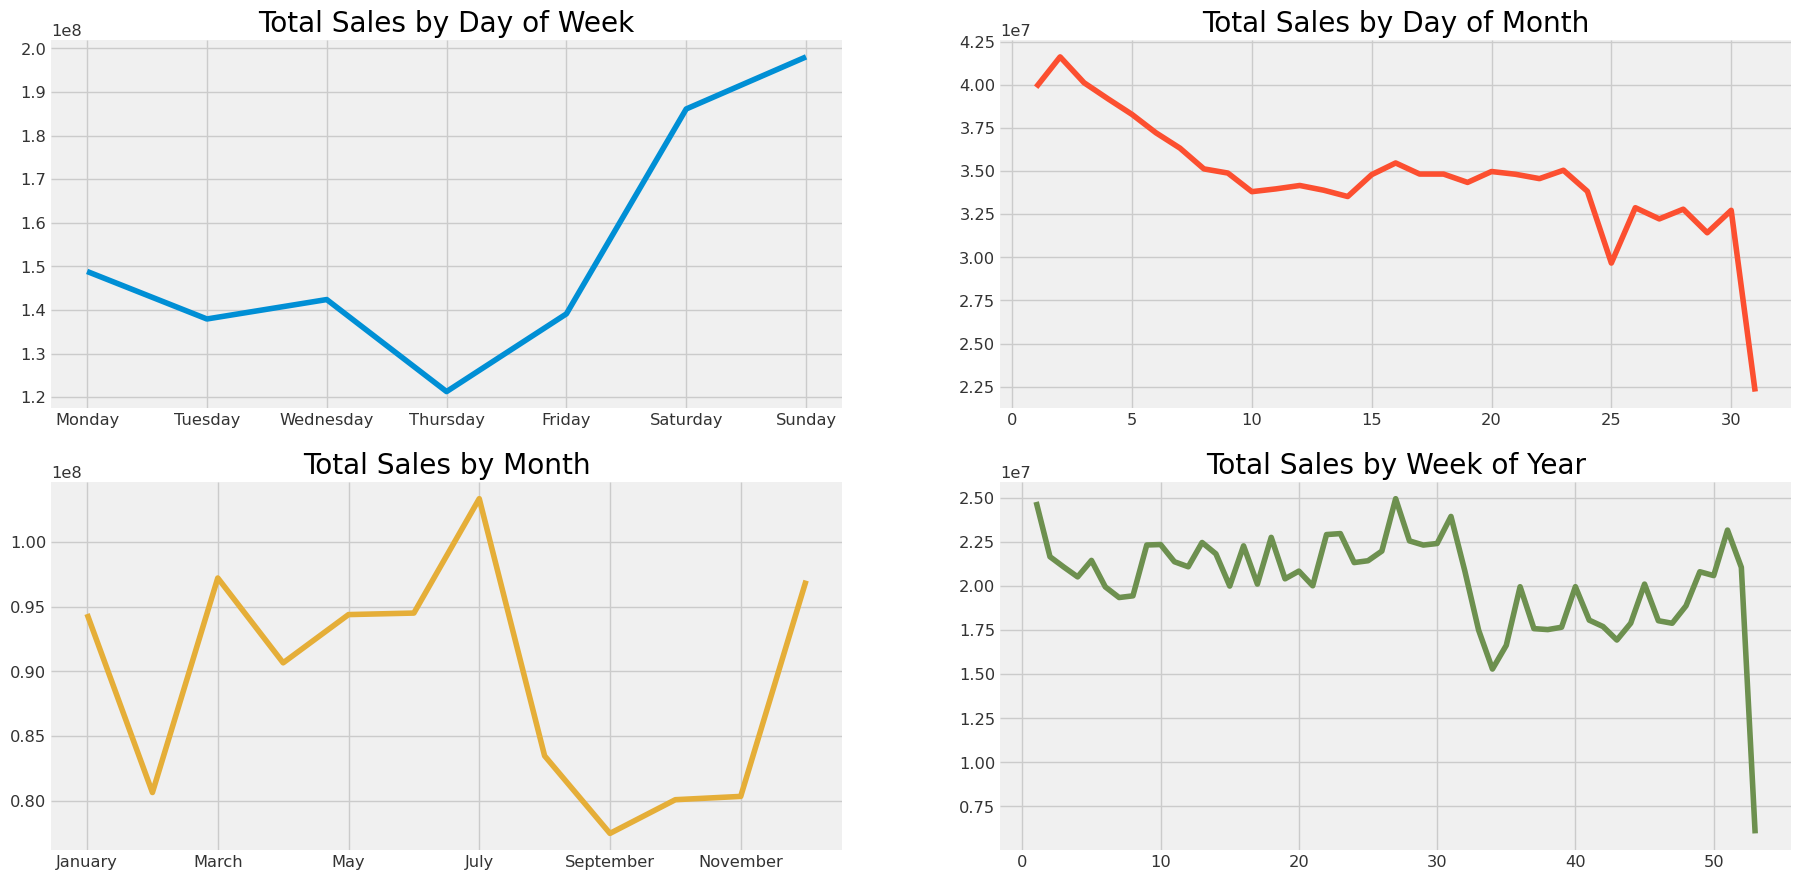

In [128]:
import seaborn as sns
plt.style.use('fivethirtyeight')

grouped = data.groupby('dayofweek')['sales'].sum()
grouped.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped2 = data.groupby('dayofmonth')['sales'].sum()
grouped2.index = range(1, 32)
grouped3 = data.groupby('month')['sales'].sum()
grouped3.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
grouped4 = data.groupby('weekofyear')['sales'].sum()
grouped4.index = range(1, 54)
fig, ax = plt.subplots(2, 2, figsize=(20, 10), facecolor='#ffffff')

grouped.plot(ax=ax[0, 0], title='Total Sales by Day of Week')
grouped2.plot(ax=ax[0, 1], title='Total Sales by Day of Month', color=color_pal[1])
grouped3.plot(ax=ax[1, 0], title='Total Sales by Month', color=color_pal[2])
grouped4.plot(ax=ax[1, 1], title='Total Sales by Week of Year', color=color_pal[3])

plt.show()

Text(0, 0.5, 'Sum of Sales')

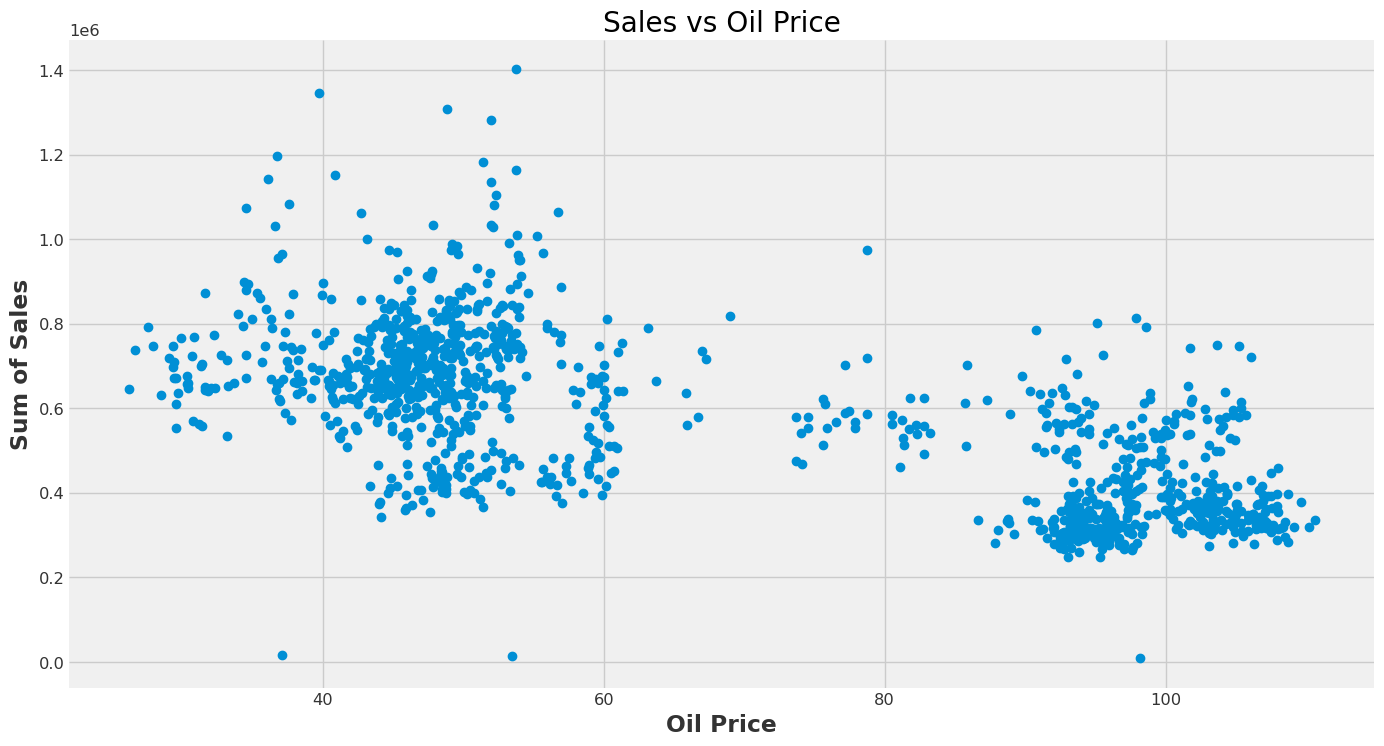

In [142]:
grouped = data.groupby('date').agg({'sales': 'sum', 'dcoilwtico': 'mean'})

plt.figure(figsize=(15, 8), facecolor='#ffffff')
plt.plot(grouped['dcoilwtico'], grouped['sales'], 'o', color=color_pal[0])
plt.title('Sales vs Oil Price')
plt.xlabel('Oil Price')
plt.ylabel('Sum of Sales')

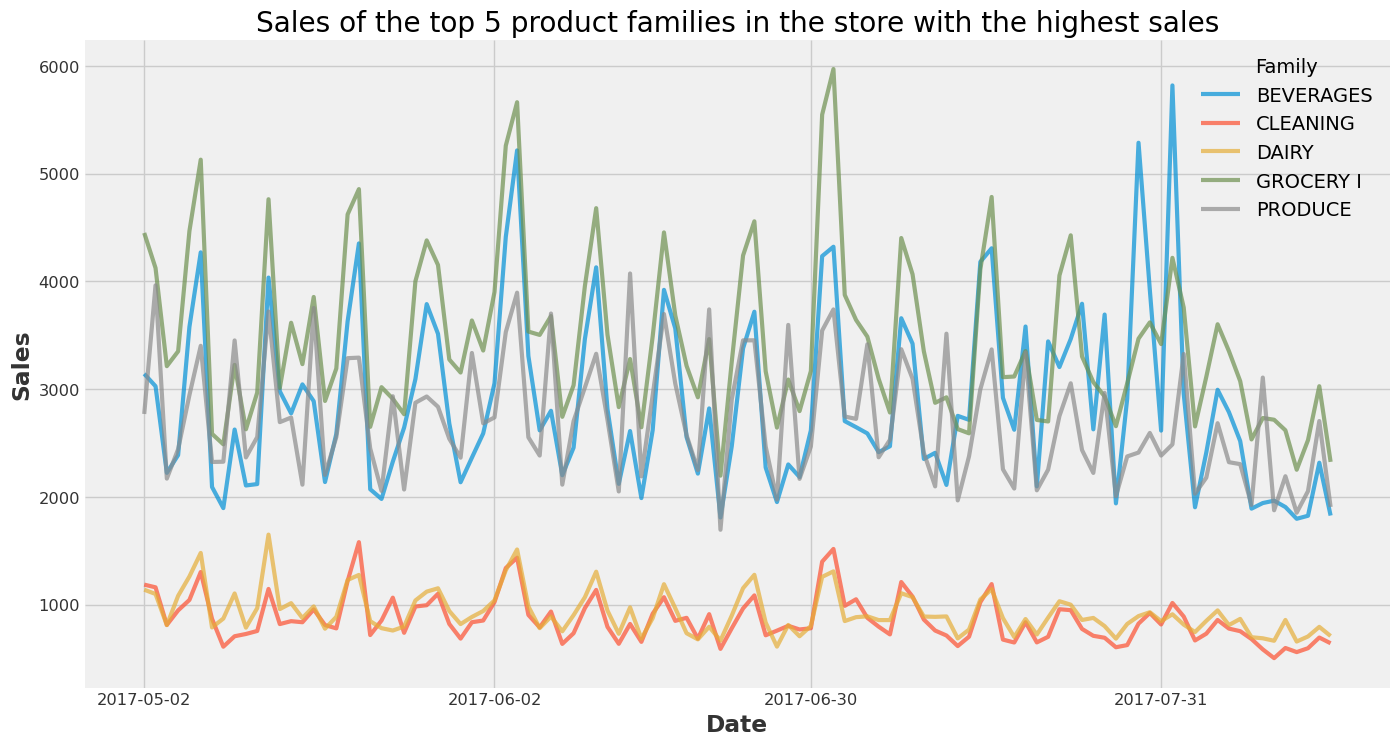

In [99]:
visualData = train.copy()
visualData = visualData[visualData['date'] > '2017-05-01']
# visualData = visualData[visualData['store_nbr'].isin(top_stores['store_nbr'].head(5))]
visualData = visualData[visualData['family'].isin(top_families['family'].head(5).map({v: k for k, v in familyCodes.items()}))]
visualData = visualData[visualData['store_nbr'] == 42]

import matplotlib.dates as mpl_dates

plt.figure(figsize=(15, 8), facecolor='#ffffff')
for family, family_data in visualData.groupby('family'):
    plt.plot(family_data['date'], family_data['sales'], label=family, linewidth=3, alpha=0.7)

plt.title('Sales of the top 5 product families in the store with the highest sales')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator())

# make legend off the plot
plt.legend(loc='upper right', title='Family')
plt.show()

In [73]:
display(stores.head())
print(len(stores['city'].unique()))
print(len(stores['state'].unique()))
print(len(stores['type'].unique()))
print(len(stores['cluster'].unique()))
print(len(data['family'].unique()))

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


22
16
5
17
33


In [74]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [76]:
train = data.loc[data['set'] == 'train'].drop('set', axis=1)
test = data.loc[data['set'] == 'test'].drop('set', axis=1)
Xtrain, ytrain = train.drop('sales', axis=1), train['sales']
Xtest, ytest = test.drop('sales', axis=1), test['sales']

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds=5, objective='reg:squarederror', max_depth=15, learning_rate=0.1, verbosity=2)
reg.fit(Xtrain, ytrain, eval_set=[(Xtrain, ytrain), (Xtest, ytest)], verbose=100)

[0]	validation_0-rmse:992.21891	validation_1-rmse:1326.11163
[100]	validation_0-rmse:47.38262	validation_1-rmse:319.14194
[113]	validation_0-rmse:44.19300	validation_1-rmse:319.11070


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0, 0.5, 'RMSE')

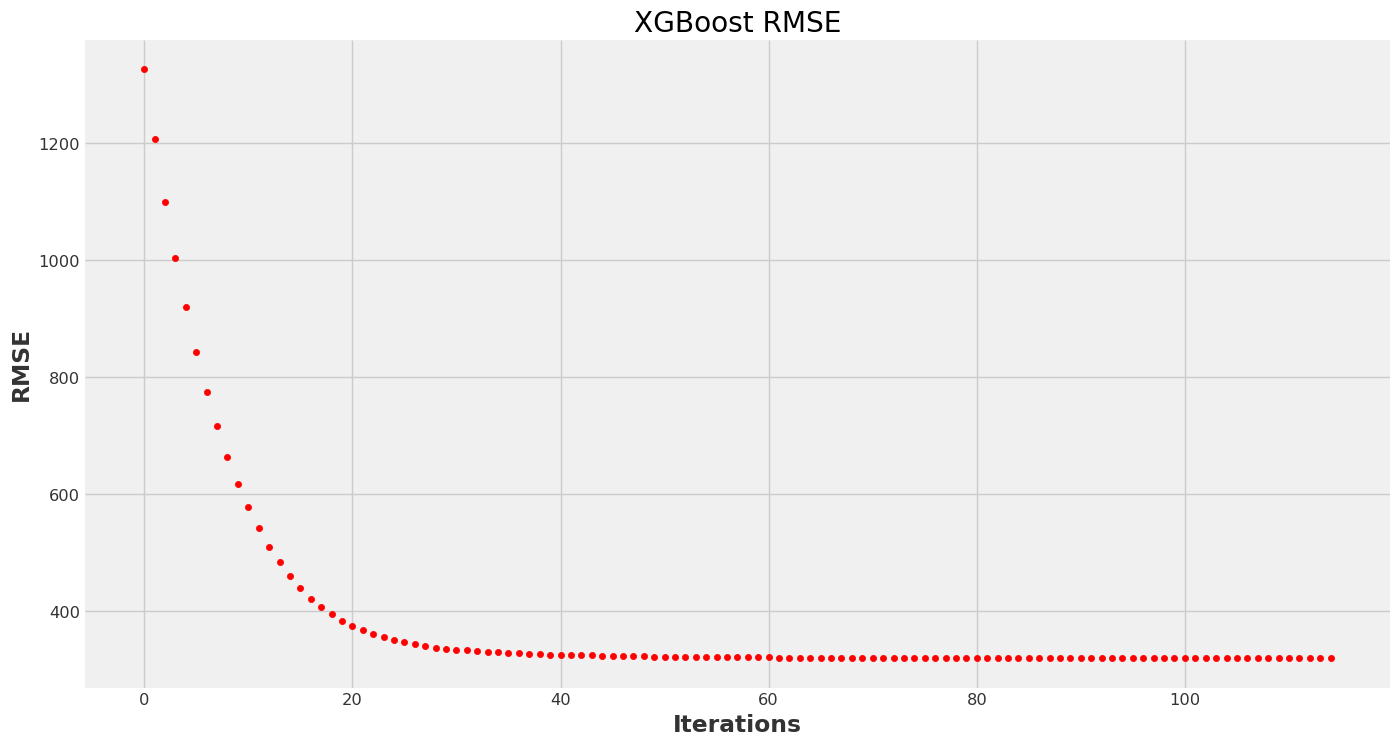

In [79]:
# Scatterplot
rmse = reg.evals_result()['validation_1']['rmse']
plt.figure(figsize=(15, 8), facecolor='#ffffff')
# plt.plot(rmse, label='Test')
plt.scatter(x=range(len(rmse)), y=rmse, label='Test', s=20, color='red')
plt.title('XGBoost RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')

In [19]:
print(familyCodes)

{'AUTOMOTIVE': 0, 'BABY CARE': 1, 'BEAUTY': 2, 'BEVERAGES': 3, 'BOOKS': 4, 'BREAD/BAKERY': 5, 'CELEBRATION': 6, 'CLEANING': 7, 'DAIRY': 8, 'DELI': 9, 'EGGS': 10, 'FROZEN FOODS': 11, 'GROCERY I': 12, 'GROCERY II': 13, 'HARDWARE': 14, 'HOME AND KITCHEN I': 15, 'HOME AND KITCHEN II': 16, 'HOME APPLIANCES': 17, 'HOME CARE': 18, 'LADIESWEAR': 19, 'LAWN AND GARDEN': 20, 'LINGERIE': 21, 'LIQUOR,WINE,BEER': 22, 'MAGAZINES': 23, 'MEATS': 24, 'PERSONAL CARE': 25, 'PET SUPPLIES': 26, 'PLAYERS AND ELECTRONICS': 27, 'POULTRY': 28, 'PREPARED FOODS': 29, 'PRODUCE': 30, 'SCHOOL AND OFFICE SUPPLIES': 31, 'SEAFOOD': 32}


In [61]:
# Make predictions
predictions = test.copy()
predictions['pred'] = reg.predict(Xtest)
display(predictions.head())
display(data.head())

predictions.reset_index(inplace=True)
data.reset_index(inplace=True)

,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,dayofweek,...,dayofmonth,weekofyear,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,pred
date,,,,,,,,,,,,,,,,,,,,,
2016-12-05,3,26,13.000,0,0,0,0,8,51.72,0,...,5,49,30.000,30.000,16.000,11.000,27.000,13.000,10.000,22.270119
2016-12-05,38,16,12.000,0,17,12,0,4,51.72,0,...,5,49,10.000,26.000,14.000,23.000,69.000,65.000,23.000,22.872772
2016-12-05,17,30,1229.659,2,0,0,1,12,51.72,0,...,5,49,1873.012,1505.295,898.658,1119.469,1157.893,2094.337,1526.787,1691.352783
2016-12-05,27,10,217.000,0,11,8,0,1,51.72,0,...,5,49,326.000,222.000,232.000,211.000,207.000,171.000,229.000,233.414398
2016-12-05,29,11,69.972,1,9,8,3,10,51.72,0,...,5,49,118.996,207.529,78.847,76.000,42.000,63.625,84.310,100.102112


,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,dayofweek,...,dayofmonth,weekofyear,set,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0.0,0,0,0,0,13,NaN,1,...,1,1,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,45,18,0.0,0,0,0,4,11,NaN,1,...,1,1,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,9,14,0.0,0,0,0,2,6,NaN,1,...,1,1,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,45,17,0.0,0,0,0,4,11,NaN,1,...,1,1,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,9,15,0.0,0,0,0,2,6,NaN,1,...,1,1,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Figure size 1500x800 with 0 Axes>

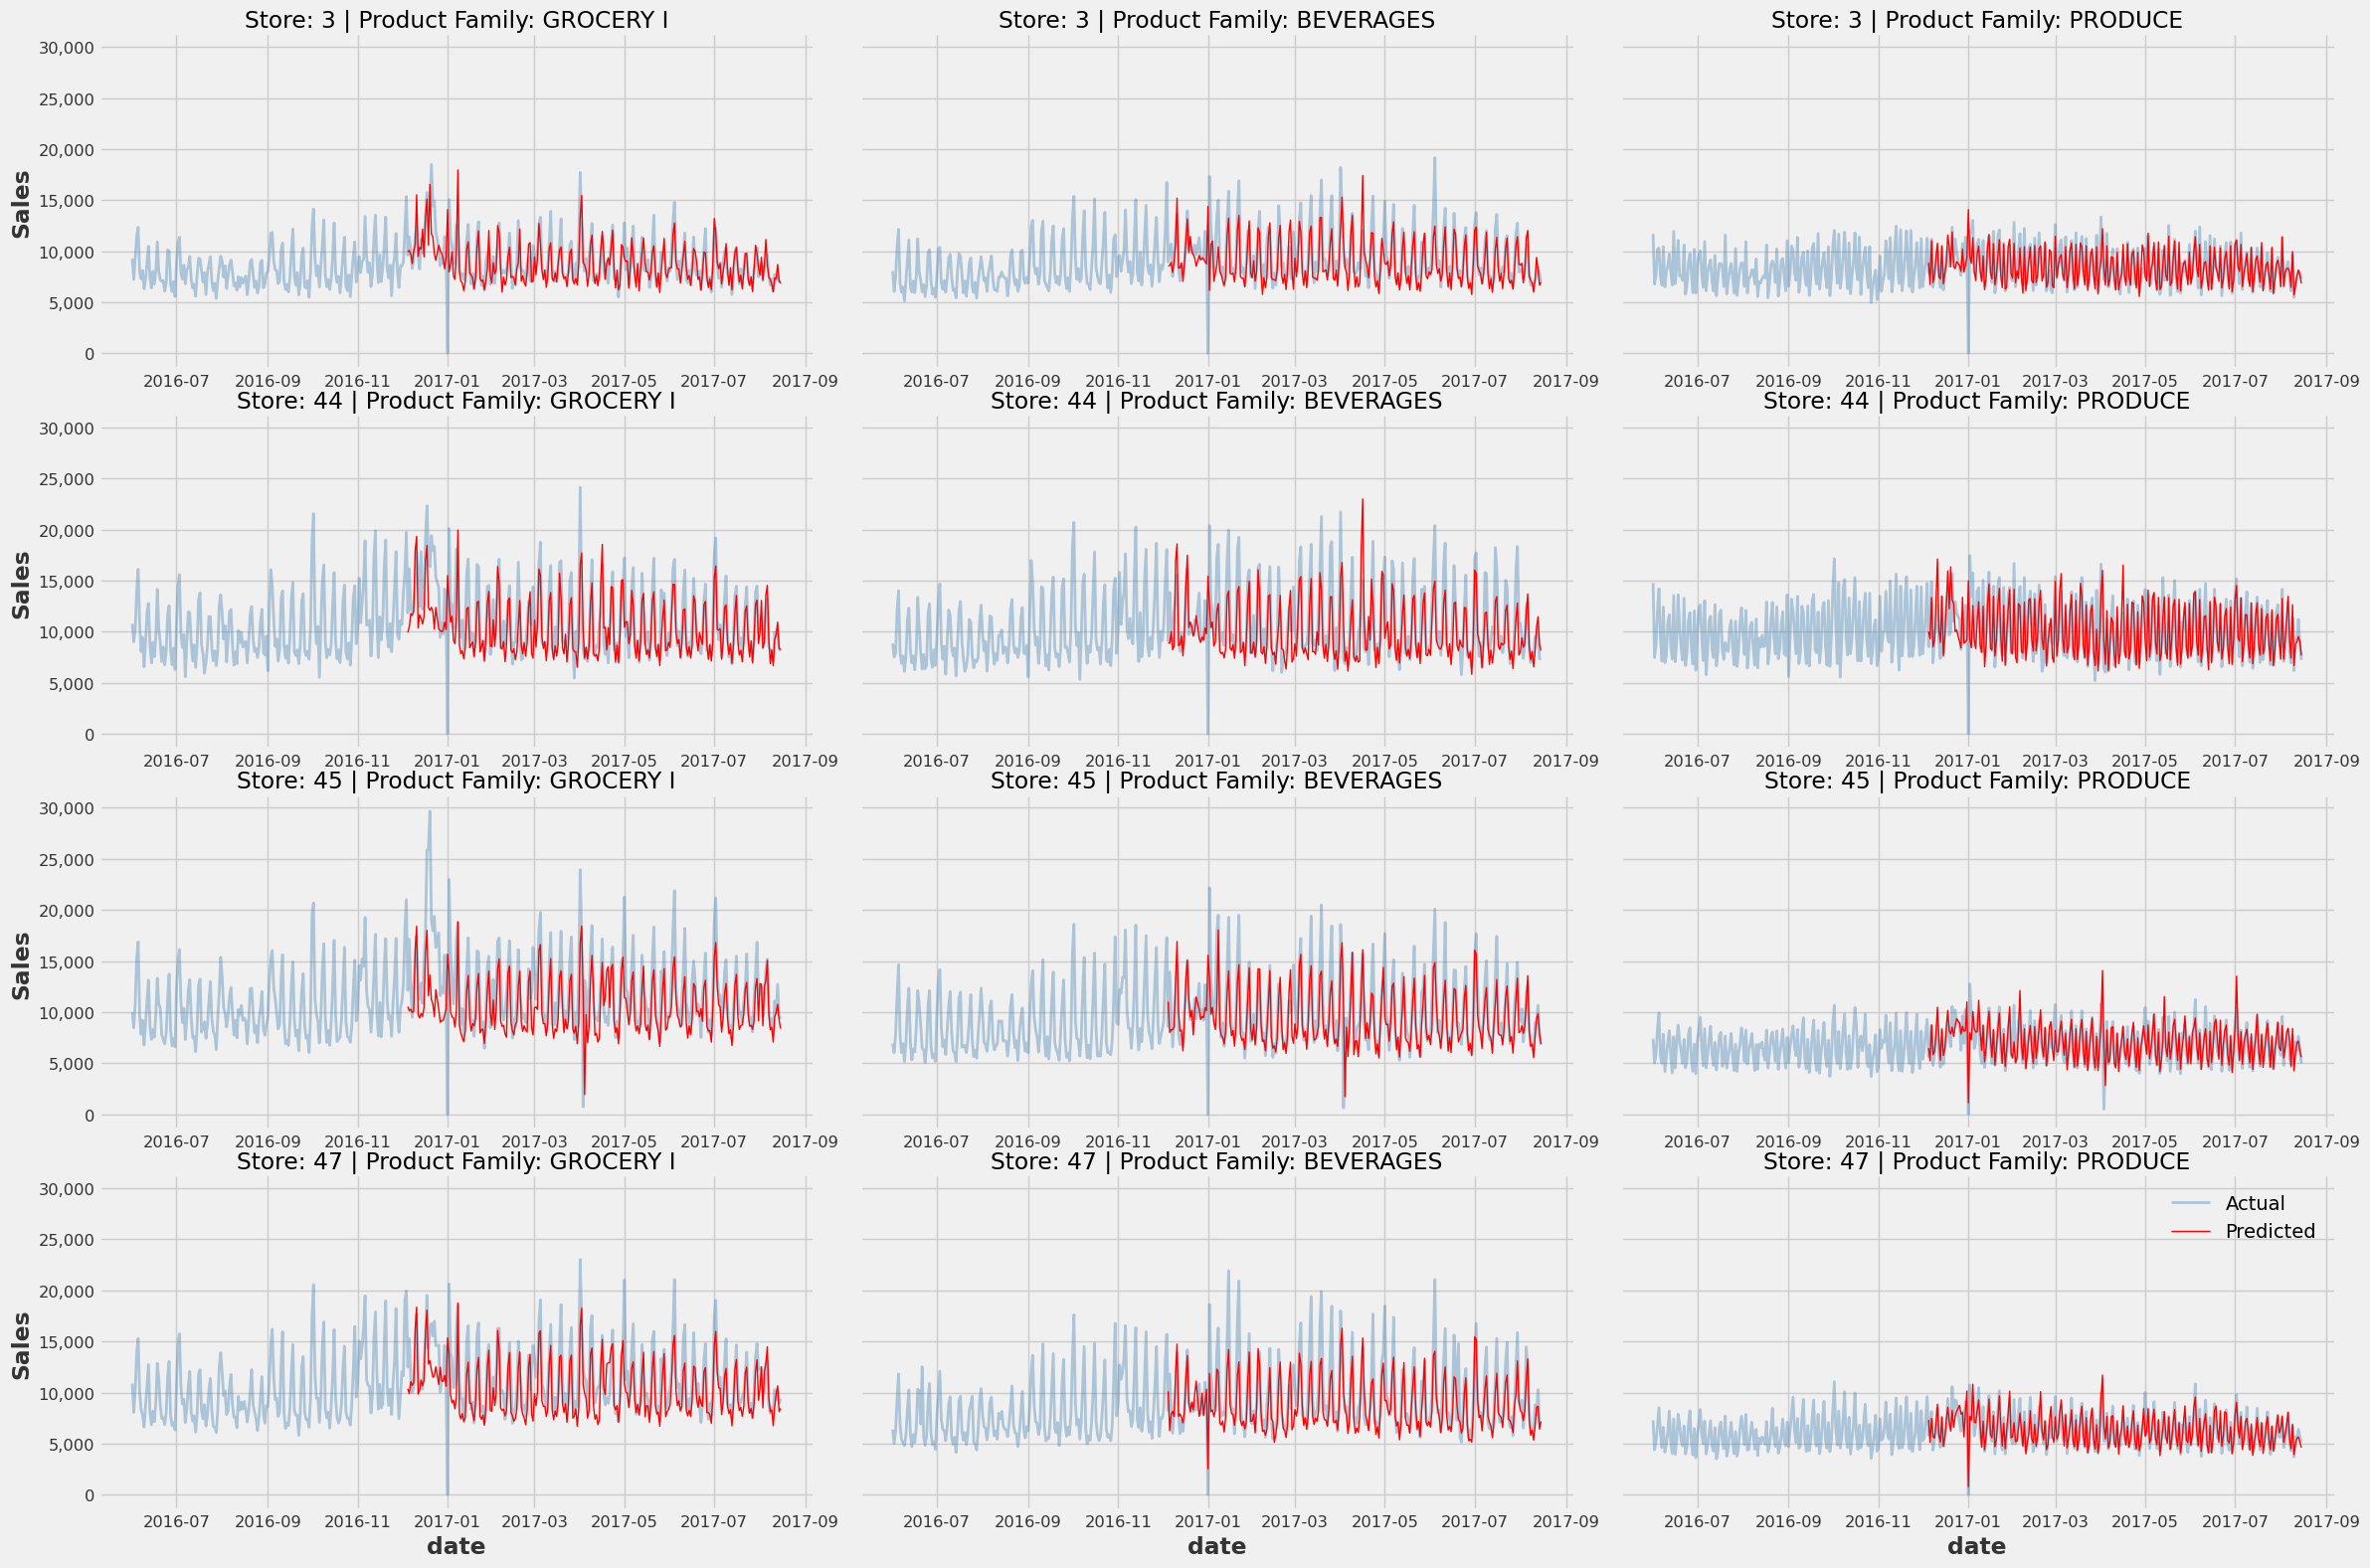

In [80]:
# Join the predictions with the original data and filter for visualization
data_new = pd.merge(data, predictions[['date', 'store_nbr', 'family', 'pred']], how='left', on=['date', 'store_nbr', 'family'])
data_new = data_new[data_new['date'] >= '2016-06-01']
data_new = data_new[data_new['store_nbr'].isin(top_stores['store_nbr'].head(4))]
data_new = data_new[data_new['family'].isin(top_families['family'].head(3))]

# Replace the family codes with the original names
data_new['family'] = data_new['family'].map({v: k for k, v in familyCodes.items()})

# Plot the results
plt.figure(figsize=(15, 8), facecolor='#ffffff')
graph = sns.FacetGrid(data_new, col="family", row='store_nbr', height=4, aspect=2)
graph.map(sns.lineplot, "date", "sales", color='steelblue', errorbar=None, linewidth=2, alpha=0.4, label='Actual')
graph.map(sns.lineplot, "date", "pred", color='red', errorbar=None, linewidth=1, label='Predicted')
graph.set_ylabels('Sales')
graph.set_titles(col_template="Product Family: {col_name}", row_template="Store: {row_name}")
# Format y-axis labels
for ax in graph.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
# Show all x-axis labels
for ax in graph.axes.flat:
    ax.tick_params(labelbottom=True)
plt.legend()

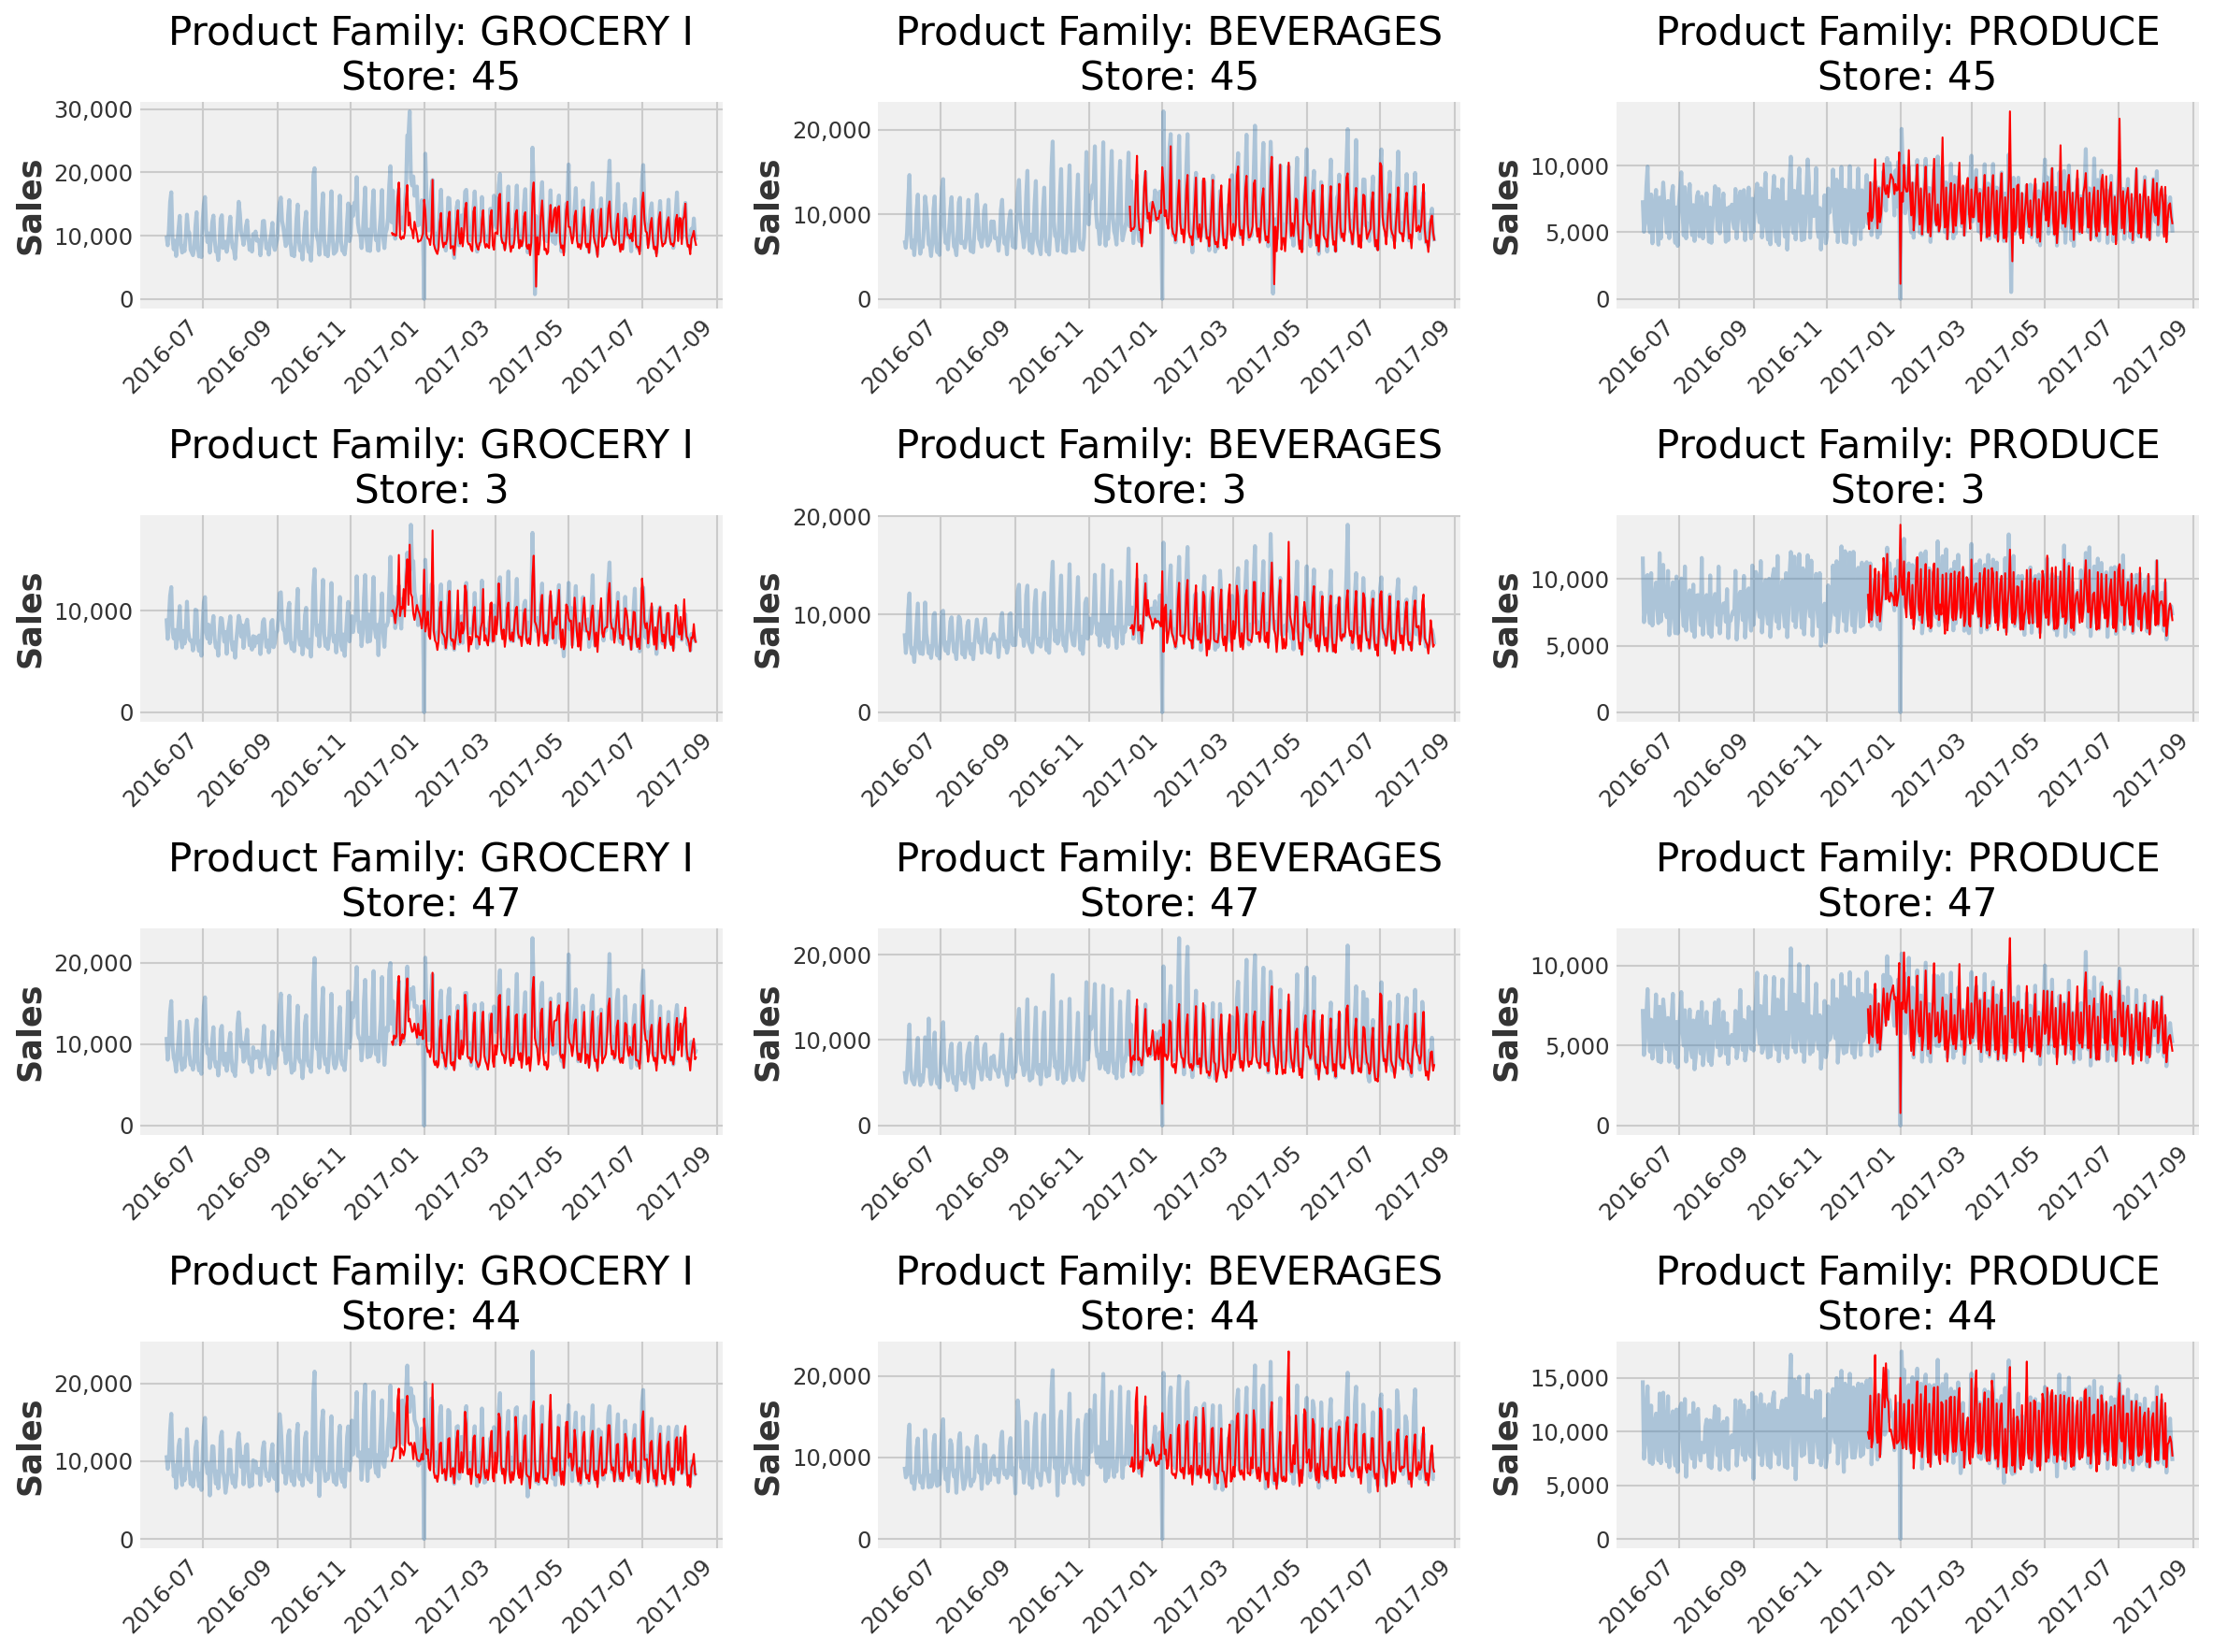

In [90]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Create FacetGrid
fig, axs = plt.subplots(data_new['store_nbr'].nunique(), data_new['family'].nunique(), figsize=(16, 12), facecolor='#ffffff', dpi=150)

for i, store in enumerate(data_new['store_nbr'].unique()):
    for j, family in enumerate(data_new['family'].unique()):
        ax = axs[i, j]
        df_subset = data_new[(data_new['store_nbr'] == store) & (data_new['family'] == family)]
        
        ax.plot(df_subset['date'], df_subset['sales'], color='steelblue', linewidth=2, alpha=0.4, label='Actual')
        ax.plot(df_subset['date'], df_subset['pred'], color='red', linewidth=1, label='Predicted')
        
        ax.set_ylabel('Sales')
        ax.set_title(f"Product Family: {family}\nStore: {store}")
        # ax.legend()
        
        # Format y-axis labels
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
        # Show all x-axis labels
        ax.tick_params(labelbottom=True)
        # rotate x-axis labels
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_horizontalalignment('right')
plt.tight_layout()
plt.show()